In [1]:
import xarray as xr
import numpy as np

import cartopy.crs as ccrs

import copy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

In [2]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

### Load targets and predicitons:

In [3]:
# ds_id = "96FE8A" # "278771"
# model_id = "290AD8" # "011A3B" "C7A2A3"

# targets = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_target.nc")
# predictions = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_gen.nc")

"""
data_template_name = "rasp_thuerey_geopotential"
experiment_name = "diffusion_rasp_thuerey_geopotential_v1"
run_date = "2023-08-23_09-50-28"
eval_date = "2023-08-23_19-51-39"
"""
# data_template_name = "geopotential_500"
# experiment_name = "diffusion_geopotential_v1"
# run_date = "2023-08-23_02-03-38"
# eval_date = "2023-08-23_09-37-13"

# data_template_name = "geopotential_500_highres"
# experiment_name = "vae_geopotential_highres_v1"
# run_date = "2023-08-23_08-33-13"
# eval_date = "2023-08-23_09-55-24"

# data_template_name = "geopotential_500_highres"
# experiment_name = "vae_geopotential_highres_v1"
# run_date = "2023-08-22_15-11-05"
# eval_date = "2023-08-22_23-42-27"


# data_template_name = "geopotential_500_highres"
# experiment_name = "fourcastnet_highres"
# run_date = "2023-08-18_13-10-40"
# eval_date = "2023-08-19_11-01-41"


"""
data_template_name = "geopotential_500"
experiment_name = "fourcastnet_small"
run_date = "2023-08-18_16-46-00"
eval_date = "2023-08-18_19-01-32"
"""

"""
data_template_name = "rasp_thuerey_geopotential"
experiment_name = "fourcastnet_rasp_thuerey"
run_date = "2023-08-18_14-18-40"
eval_date = "2023-08-18_17-47-29"
"""



data_template_name = "geopotential_500_highres"
experiment_name = "fourcastnet_highres"
run_date = "2023-08-17_20-18-22"
eval_date = "2023-08-18_12-11-04"

"""
data_template_name = "geopotential_500"
experiment_name = "fourcastnet"
run_date = "2023-08-18_13-10-44"
eval_date = "2023-08-18_16-07-24"
"""

targets = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{data_template_name}/{experiment_name}/{run_date}/{eval_date}/target.nc")
predictions = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{data_template_name}/{experiment_name}/{run_date}/{eval_date}/gen.nc")

diff = targets - predictions

n_images = 8

timesteps = np.random.choice(np.arange(len(predictions["init_time"])), size=(n_images,))

In [4]:
# do configurations for plotting - these can also be shared or "inherited" for plots that are similar!

config = {
    "CMAP": "viridis",
    "NORM": matplotlib.colors.Normalize(vmin=49000, vmax=59000),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": True,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "both",
    "SHOW_COLORBAR_LABEL": False,
    "CBAR_LABEL": r"Geopotential [$m^2/s^2$]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 6/5  # can be used to calculate a figsize that looks nice for a given type of plot
}


config_diff = copy.deepcopy(config)

config_diff["CMAP"] = "RdBu"
config_diff["NORM"] = matplotlib.colors.Normalize(vmin=-3000, vmax=3000)

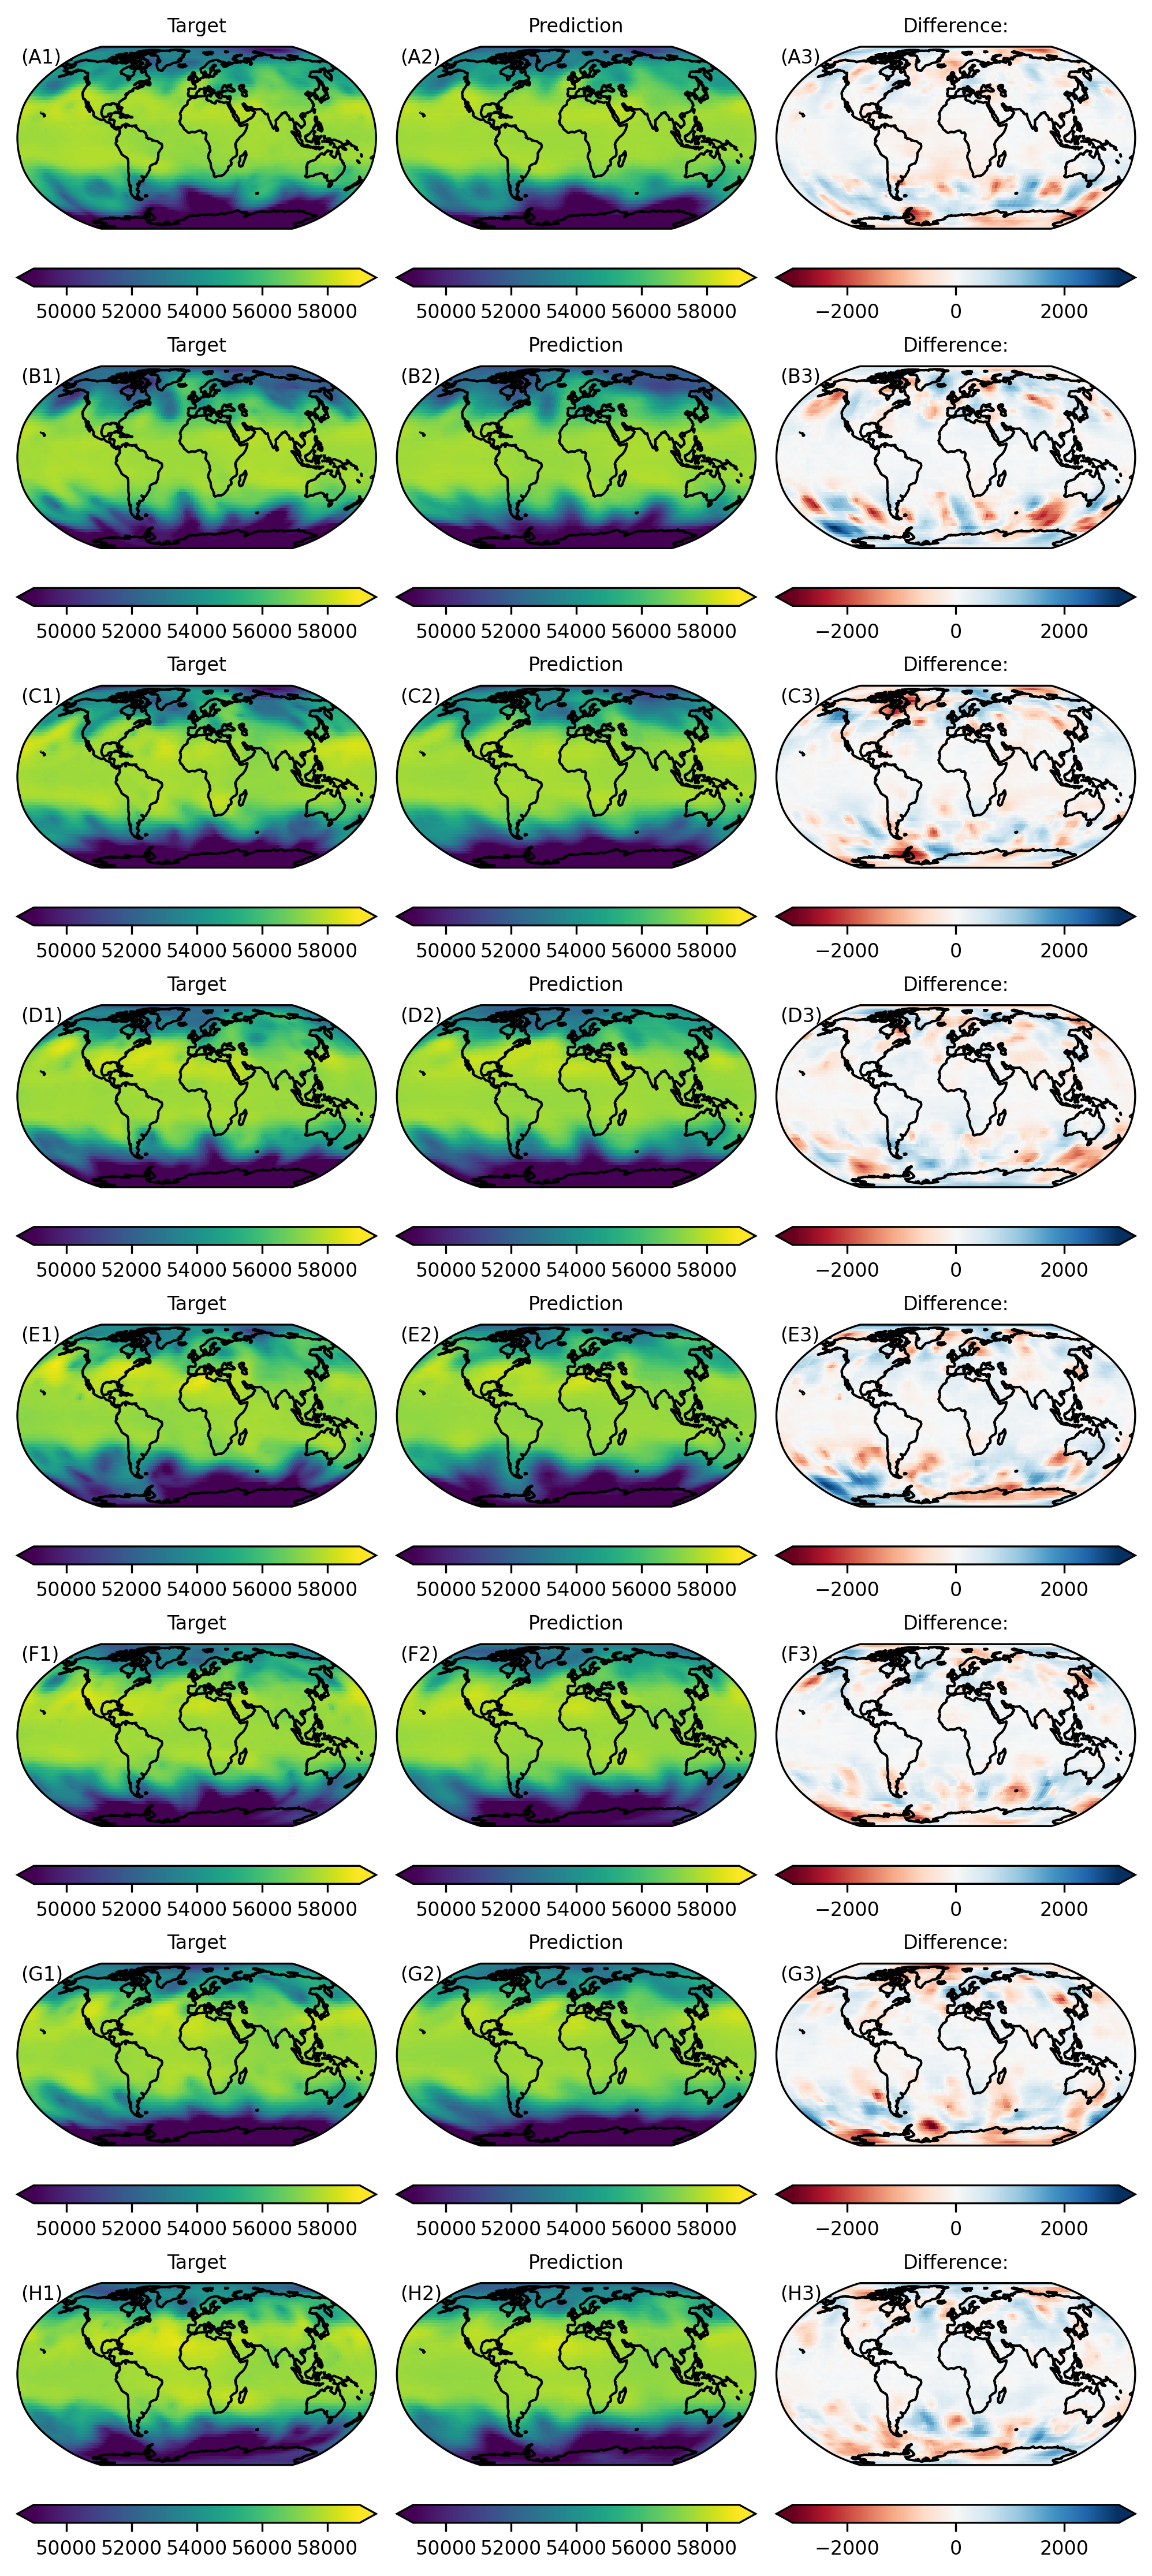

In [5]:
n_rows = n_images
n_cols = 3

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1,1,1])

for i, i_t in enumerate(timesteps):
    ax = fig.add_subplot(gs[i, 0], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=targets.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(targets.keys())], plotting_config=config, title="Target")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}1)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 1], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=predictions.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(predictions.keys())], plotting_config=config, title="Prediction")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}2)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 2], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=diff.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(diff.keys())], plotting_config=config_diff, title="Difference:")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}3)".format(alphabet_letters[i]))

fig.canvas.draw()
fig.tight_layout()

plt.show()

### Compute RMSE:

In [6]:
from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc

In [7]:
predictions.mean(dim="ensemble_member")

<xarray.Dataset>
Dimensions:    (init_time: 2904, lat: 64, lon: 128, lead_time: 1)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2017-01-01T06:00:00 ... 2018-12-28
  * lat        (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lead_time  (lead_time) int64 12
Data variables:
    z_500      (init_time, lead_time, lat, lon) float32 5.083e+04 ... 4.853e+04

In [8]:
rmse = compute_weighted_rmse(predictions.isel({"ensemble_member": 0}), targets.isel({"ensemble_member": 0}))
print("RMSE is {:.1f}".format(rmse.z_500.values))

mae = compute_weighted_mae(predictions.isel({"ensemble_member": 0}), targets.isel({"ensemble_member": 0}))
print("MAE is {:.1f}".format(mae.z_500.values))

acc = compute_weighted_acc(predictions.isel({"ensemble_member": 0}), targets.isel({"ensemble_member": 0}))
print("ACC is {:.2f}".format(acc.z_500.values))

RMSE is 447.4


MAE is 282.2
ACC is 0.91


In [9]:
rmse = compute_weighted_rmse(predictions.mean(dim = "ensemble_member"), targets.isel({"ensemble_member": 0}))
print("RMSE is {:.1f}".format(rmse.z_500.values))

mae = compute_weighted_mae(predictions.mean(dim = "ensemble_member"), targets.isel({"ensemble_member": 0}))
print("MAE is {:.1f}".format(mae.z_500.values))

acc = compute_weighted_acc(predictions.mean(dim = "ensemble_member"), targets.isel({"ensemble_member": 0}))
print("ACC is {:.2f}".format(acc.z_500.values))

RMSE is 447.4
MAE is 282.2
ACC is 0.91


In [10]:
from WD.regridding import regrid_to_res

In [11]:
interpolated_predictions = regrid_to_res(predictions, "5.625deg", reuse_weights=False)

interpolated_targets = regrid_to_res(targets, "5.625deg", reuse_weights=False)

Overwrite existing file: bilinear_64x128_32x64_peri.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable z_500 as the horizontal dimensions for this dataset.


/home/wider/.conda/envs/WD_eval/lib/python3.9/site-packages/xesmf/frontend.py:477: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


Overwrite existing file: bilinear_64x128_32x64_peri.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable z_500 as the horizontal dimensions for this dataset.


/home/wider/.conda/envs/WD_eval/lib/python3.9/site-packages/xesmf/frontend.py:477: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


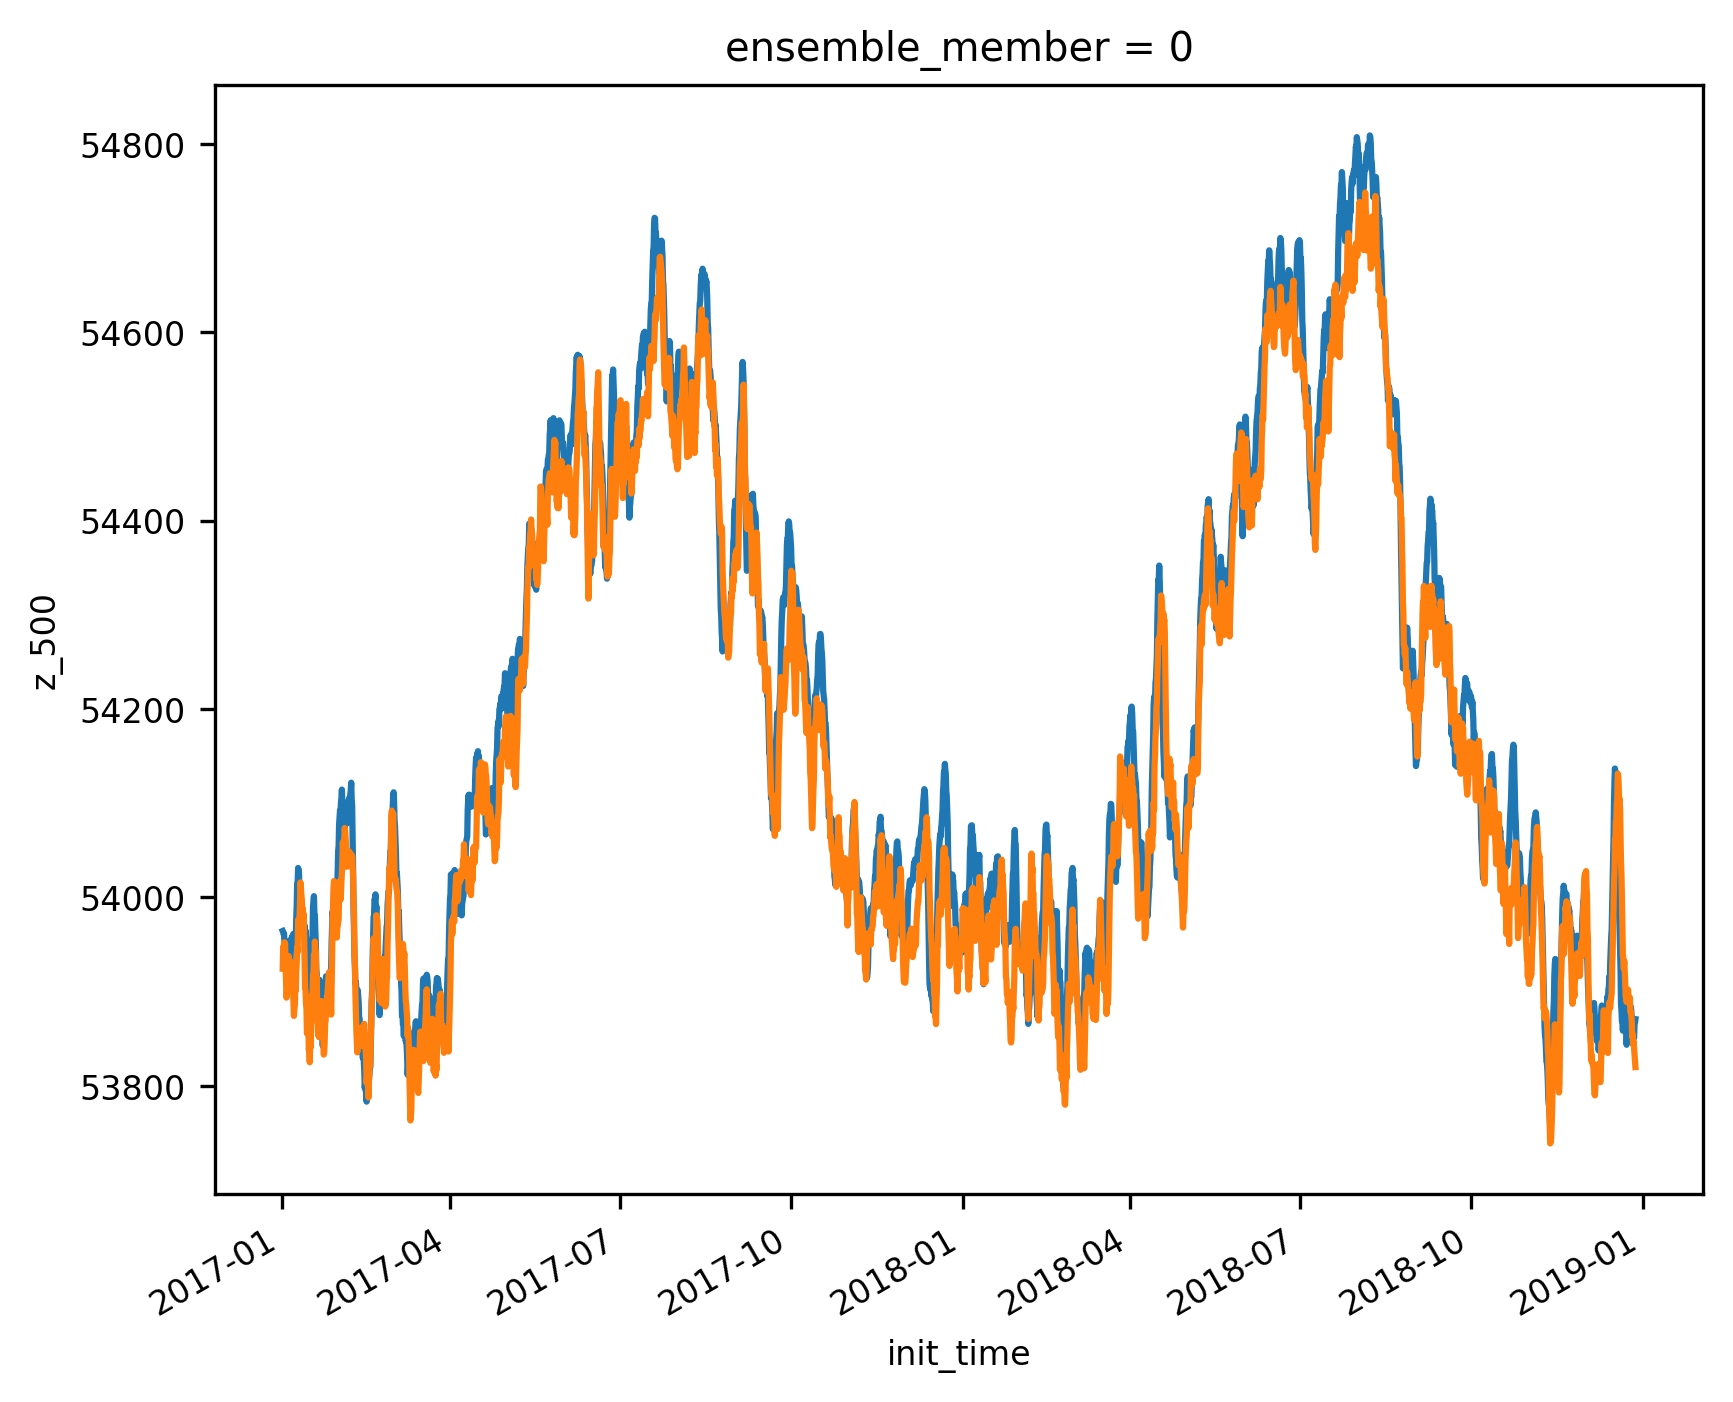

In [12]:
interpolated_targets.mean(("lat", "lon", "lead_time")).z_500.plot()
interpolated_predictions.mean(("lat", "lon", "lead_time")).z_500.plot()

In [13]:
rmse = compute_weighted_rmse(interpolated_predictions.isel({"ensemble_member": 0}), interpolated_targets.isel({"ensemble_member": 0}))
print("RMSE of interpolated data is {:.1f}".format(rmse.z_500.values))

mae = compute_weighted_mae(interpolated_predictions.isel({"ensemble_member": 0}), interpolated_targets.isel({"ensemble_member": 0}))
print("MAE of interpolated data is {:.1f}".format(mae.z_500.values))

acc = compute_weighted_acc(interpolated_predictions.isel({"ensemble_member": 0}), interpolated_targets.isel({"ensemble_member": 0}))
print("ACC of interpolated data is {:.2f}".format(acc.z_500.values))

RMSE of interpolated data is 435.7
MAE of interpolated data is 275.3
ACC of interpolated data is 0.91
